<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Сезонность" data-toc-modified-id="Сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сезонность</a></span></li><li><span><a href="#Тренд" data-toc-modified-id="Тренд-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Предсказания-по-последнему-значению" data-toc-modified-id="Предсказания-по-последнему-значению-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Предсказания по последнему значению</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-модели" data-toc-modified-id="Анализ-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Задача**

>Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, **нужно спрогнозировать количество заказов такси на следующий час**. Постройте модель для такого предсказания.
>
>Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
>
>Вам нужно:
>
>1. Загрузить данные и выполнить их ресемплирование по одному часу.
>2. Проанализировать данные.
>3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
>4. Проверить данные на тестовой выборке и сделать выводы.
>
>Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель работы:**
- Исследовать данные о заказах;
- Построить модели предсказывающие количество заказов на следующий час по предшествующим данным;
- Добиться качества предсказаний модели по метрике RMSE не более 48.

## Загрузка данных

Импортируем необходимые библиотеки.

In [1]:
#%pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

Загрузим файл CSV и сохраним его в переменную *data*. Атрибут `parse_dates` позволяет сразу перевести тип данных в datetime в указанном столбце.

In [3]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим корректно ли загружены данные и общую информацию.

In [4]:
data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные загружены корректно. Можно сделать некоторые замечания:
- Столбец *datetime* является индексом таблицы и имеет тип Datetime.
- В столбце *num_orders* содержится число - количество заказов.
- Временной промежуток между записями - 10 минут.

Исследуем значения столбца *num_orders*.

In [5]:
data['num_orders'].describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Данные готовы для дальнейшего анализа.

## Анализ данных

Проверим как расположены данные по времени. Для анализа временных рядов важно, чтобы данные были расположены в хронолигическом порядке.

In [6]:
if data.index.is_monotonic:
    print('Данные расположены в хронологическом порядке')
else:
    print('Порядок данных не последовавтельный')

Данные расположены в хронологическом порядке


Нам необходимо сделать предсказания на временной промежуток в 1 час. Для этого в обучающих данных изменим шаг между записями. Ресемплируем данные по 1 часу, суммируя промежуточные данные.

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
print(f'Временной промежуток выборки:\n{data.index.min()} - {data.index.max()}')

Временной промежуток выборки:
2018-03-01 00:00:00 - 2018-08-31 23:00:00


Проверим скользящее среднее и скользящее среднеквадратичное отклонение, ширину окна зададим 72.

In [9]:
rolling_df = data[['num_orders']].copy()
rolling_df['rolling_mean'] = rolling_df['num_orders'].rolling(72).mean()
rolling_df['rolling_std'] = rolling_df['num_orders'].rolling(72).std()

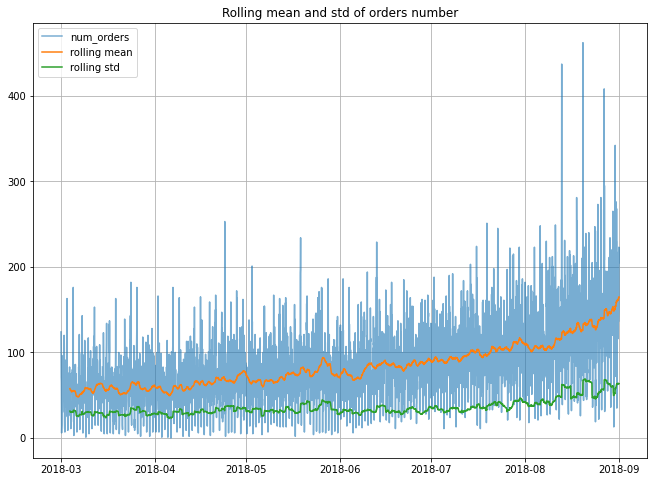

In [10]:
fig = plt.figure(figsize=(11,8))

ax = fig.add_subplot(1, 1, 1)
ax.grid()
ax.plot(rolling_df['num_orders'], alpha=0.6)
ax.plot(rolling_df[['rolling_mean', 'rolling_std']])
plt.legend(['num_orders', 'rolling mean', 'rolling std'])
plt.title('Rolling mean and std of orders number')
plt.show()

Можно наблюдать восходящий тренд скользящего среднего и среднеквадратичного отклонения. 

Разложим временной ряд на компоненты и поищем в них закономерности.

### Сезонность

С помощью функции `seasonal_decompose` временной ряд можно разложить на составляющие: сезонность, тренд и оставшийся шум. Мы исследуем сезонность и тренд.

Исследуем сезонность для периодов неделя и день.

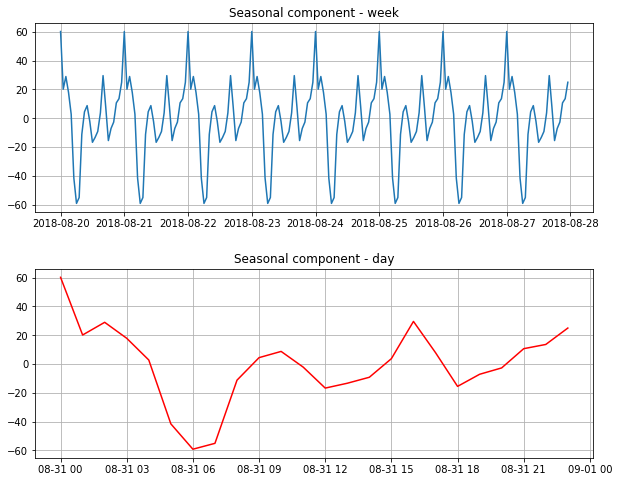

In [11]:
decompose = seasonal_decompose(data[['num_orders']])

fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(decompose.seasonal['2018-08-20':'2018-08-27'])
ax1.grid()
ax1.set_title('Seasonal component - week')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(decompose.seasonal['2018-08-31'], color='red')
ax2.grid()
ax2.set_title('Seasonal component - day')
plt.show()

**Компонент сезонности четко прослеживается в масштабе одного дня**. Наибольшее падение наблюдается утром, около 6 часов, а рост ночью, ближе к полуночи.

### Тренд

Исследуем тренд на временных промежутках месяц и неделя. 

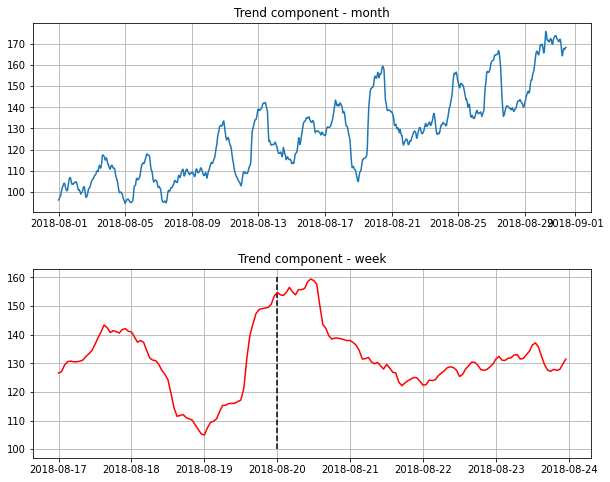

In [12]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(decompose.trend['2018-08'])
ax1.grid()
ax1.set_title('Trend component - month')

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(decompose.trend['2018-08-17':'2018-08-23'], color='red')
ax2.vlines('2018-08-20', 100, 160, linestyles='dashed', color='black')
ax2.grid()
ax2.set_title('Trend component - week')
plt.show()

Наблюдается два тренда временного ряда:
- **Глобальный тренд на увеличение числа заказов к концу лета**;
- **Повторяющийся недельный тренд**. Минимум достигается в воскресение, а повышение спроса происходит в двух точках - с воскресения на понедельник и с пятницы на субботу.

### Вывод

Имеющиеся данные представляют собой количество заказов во временной промежуток 10 минут с марта по август 2018 года. В предподготовке данные были ресемплированы по 1 часу.

В ходе анализа данных были замечены следующие закономерности:
- К настоящему моменту наблюдается тренд на увеличение скользящего среднего и среднеквадратического отклонения, имеется глобальный тренда на увеличение заказов;
- Количество заказов меняется в течении недели с пиками в пятница-суббота и воскресение-понедельник и минимумом в воскресение;
- Количество заказов менятся в течении дня, наибольшее количество ночью, около 12 часов, наименьшее к 6 утра.

Для предсказания количества заказов важными будут являться: месяц, день недели и час дня. Необходимо выделить эти параметры как отдельные признаки в обучающей и тестовой выборках.

## Обучение моделей

Для предсказаний числа заказов используем алгоритмы машинного обучения. Напишем функции, которые помогут подготовить наборы данных.

In [13]:
def fetures_target_split(df, y_name='num_orders'):
    x = df.drop([y_name], axis=1)
    y = df[y_name]
    return x, y

def make_sets(df, rolling_size, max_lag):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['month'] = df.index.month

    for lag in range(max_lag):
        df[f'lag_{lag+1}'] = df['num_orders'].shift(lag+1)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()
    
    df = df.dropna(axis=0)
    x, y = fetures_target_split(df)
    return x, y

def rmse(model, x, y):
    predictions = model.predict(x)
    return round(mean_squared_error(y, predictions)**0.5, 3) 

Разделим набор данных на обучающую, валидационную и тестовую выборки в соотношении 8:1:1.

In [14]:
train_valid, test = train_test_split(data.copy(), shuffle=False, train_size=0.9)
train, valid = train_test_split(train_valid.copy(), shuffle=False, test_size=test.shape[0])
pd.DataFrame([train.shape[0], valid.shape[0], test.shape[0]], index=['train', 'valid', 'test'], columns=['rows'])

,rows
train,3532
valid,442
test,442


При разделении выборки важно учесть последовательность записей. Тестовая выборка должна по времени следовать после обучающей, иначе модель обучится на данных "из будущего". 

In [15]:
print('Временной промежуток выборок\nTrain: {} - {}\nTest: {} - {}'
      .format(train_valid.index.min(), train_valid.index.max(), test.index.min(), test.index.max()))

Временной промежуток выборок
Train: 2018-03-01 00:00:00 - 2018-08-13 13:00:00
Test: 2018-08-13 14:00:00 - 2018-08-31 23:00:00


Набор данных был корректно разделен на обучающую и тестовую.

### Предсказания по последнему значению

Чтобы оценить адекватность модели, нам нужно ее с чем-то сравнить. Для этого создадим простую предсказательную модель, которая будет предсказывать количество заказов по последнему значению. Качество моделей будем контролировать метрикой RMSE.

In [16]:
predictions = valid.shift(fill_value=train.iloc[-1, 0])
results = pd.DataFrame([round(mean_squared_error(valid, predictions)**0.5, 3)],
                       columns=['rmse'],
                       index=['Previous value'])
results

,rmse
Previous value,47.246


### Linear Regression

Используем модель линейной регрессии. На этой моделе подберем параметры для выделения новых признаков из временного ряда, такие как ширина окна для скользящего среднего и число прошлых значений целевого признака.

In [17]:
params = {
    'rolling_size': [24, 48, 72],
    'max_lag': [12, 24, 48]
}
grid_result = pd.DataFrame(columns=['rolling_size', 'max_lag', 'rmse'])

for rolling_size in params['rolling_size']: 
    for max_lag in params['max_lag']:
        
        train_x, train_y = make_sets(train, rolling_size, max_lag)
        valid_x, valid_y = make_sets(valid, rolling_size, max_lag)
        
        model = LinearRegression()
        model.fit(train_x, train_y)
        metric = rmse(model, valid_x, valid_y)
        grid_result.loc[grid_result.shape[0]] = [rolling_size, max_lag, metric]
        
        
display(grid_result)
display(grid_result[grid_result['rmse']==grid_result['rmse'].min()])

,rolling_size,max_lag,rmse
0,24.0,12.0,40.255
1,24.0,24.0,34.306
2,24.0,48.0,31.539
3,48.0,12.0,40.139
4,48.0,24.0,34.264
5,48.0,48.0,31.540
6,72.0,12.0,40.131
7,72.0,24.0,34.069
8,72.0,48.0,31.588


,rolling_size,max_lag,rmse
2,24.0,48.0,31.539


Лучшие результаты удалось получить со значениями ширины окна 24 и числа предыдущих значений 48. Используем эти параметры, обучим модель заново и сохраним результат в таблицу.

In [18]:
train_x, train_y = make_sets(train, 24, 48)
valid_x, valid_y = make_sets(valid, 24, 48)

model = LinearRegression()
model.fit(train_x, train_y)
results.loc['LinearRegression'] = rmse(model, valid_x, valid_y)
results

,rmse
Previous value,47.246
LinearRegression,31.539


Результат LinearRegression значительно лучше простой модели.

### RandomForest

Используем модель случайного леса. Подберем параметры глубины деревьев и минимального числа объектов для разделения. Подбор параметров произведем с помощью функции GridSearchCV, которая использует кросс-валидацию. Для разделения выборки на обучающую и валидационную не подойдет стандартный метод. Для временных рядов используют метод TimeSeriesSplit, который не допускает обучения на данных "из будущего".

In [19]:
params = {
    'max_depth': [9, 12, 15],
    'min_samples_split': [3, 6, 9]
}
ts_folds = TimeSeriesSplit(3)

model = RandomForestRegressor(n_estimators=50, random_state=12345, criterion='mse')
grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=ts_folds, refit=False, n_jobs=-1)
grid.fit(train_x, train_y)

grid_result = pd.DataFrame(grid.cv_results_)[['param_max_depth', 'param_min_samples_split', 'mean_test_score']]
grid_result.columns = ['max_depth', 'min_samples_split', 'mse']
display(grid_result)
display(grid_result[grid_result['mse']==grid_result['mse'].max()])

,max_depth,min_samples_split,mse
0,9,3,-564.416352
1,9,6,-565.369516
2,9,9,-567.599991
3,12,3,-557.366630
4,12,6,-557.715550
5,12,9,-559.021108
6,15,3,-558.703659
7,15,6,-555.416970
8,15,9,-558.429634


,max_depth,min_samples_split,mse
7,15,6,-555.41697


Лучший результат получили с параметрами глубины деревьев 15 и числом объектов для разделения 6. Обучим модель заново и получим предсказания на валидационной выборке.

In [20]:
model = RandomForestRegressor(n_estimators=50,
                                 random_state=12345,
                                 criterion='mse',
                                 max_depth=15, 
                                 min_samples_split=6, 
                                 n_jobs=-1)
model.fit(train_x, train_y)

results.loc['RandomForest'] = rmse(model, valid_x, valid_y)
results

,rmse
Previous value,47.246
LinearRegression,31.539
RandomForest,32.532


### LightGBM

Применим градиентный бустинг для решения задачи. Подберем параметры глубины деревьев и шаг обучения.

In [21]:
params = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.1, 0.12, 0.15]
}
ts_folds = TimeSeriesSplit(3)

model = LGBMRegressor(n_estimators=100, random_state=12345)
grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=ts_folds, refit=False)
grid.fit(train_x, train_y)

grid_result = pd.DataFrame(grid.cv_results_)[['param_max_depth', 'param_learning_rate', 'mean_test_score']]
grid_result.columns = ['max_depth', 'learning_rate', 'mse']
display(grid_result)
display(grid_result[grid_result['mse']==grid_result['mse'].max()])

,max_depth,learning_rate,mse
0,6,0.1,-549.238429
1,8,0.1,-547.770423
2,10,0.1,-559.771583
3,6,0.12,-557.124604
4,8,0.12,-552.634955
5,10,0.12,-554.066744
6,6,0.15,-561.293590
7,8,0.15,-573.962818
8,10,0.15,-554.587636


,max_depth,learning_rate,mse
1,8,0.1,-547.770423


Лучшие результаты получили с параметрами глубины деревьев 8 и шагом обучения 0.1.

In [22]:
model = LGBMRegressor(n_estimators=100, random_state=12345, max_depth=8, learning_rate=0.1)
model.fit(train_x, train_y)

results.loc['Light GBM'] = rmse(model, valid_x, valid_y)
results

,rmse
Previous value,47.246
LinearRegression,31.539
RandomForest,32.532
Light GBM,31.367


Построим график результатов разных моделей машинного обучения и выберем лучший вариант.

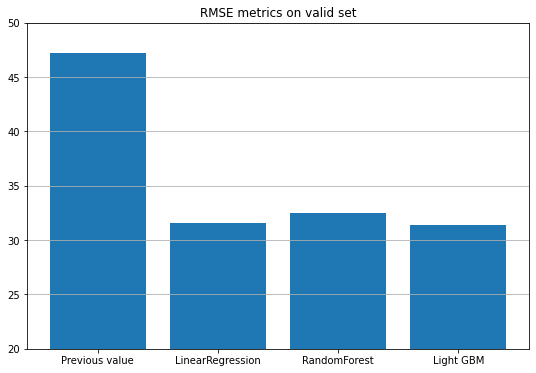

In [23]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.bar(x=results.index, height=results['rmse'])
ax1.grid(axis='y')
ax1.set_ylim(20, 50)
ax1.set_title('RMSE metrics on valid set')
plt.show()

### Вывод

Были обучены различные модели машинного обучения, среди которых базовая простая модель, линейная регрессия, случайный лес и градиентный бустинг. Заказчиком заявлен максимальный RMSE, равный 48. Все результаты оказались лучше порогового значения. **Наилучший результат на обучении показала модель LightGBM**, эту модель будем использовать для предсказаний на тестовой выборке.

## Анализ модели

Составим новую обучающую выборку, совместно с валидационной выборкой. 

In [24]:
train_x, train_y = make_sets(train_valid, 24, 48)
test_x, test_y = make_sets(test, 24, 48)

Получим предсказания на тестовой выборке и вычислим среднюю абсолютную ошибку предсказаний.

In [25]:
model = LGBMRegressor(n_estimators=100, random_state=12345, max_depth=8, learning_rate=0.1)
model.fit(train_x, train_y)

print('RMSE на тестовой выборке: {:.3f}'.format(rmse(model, test_x, test_y)))

RMSE на тестовой выборке: 40.242


Представим на графике результаты предсказаний на тестовой выборке и реальные значения количества заказов и сравним их.

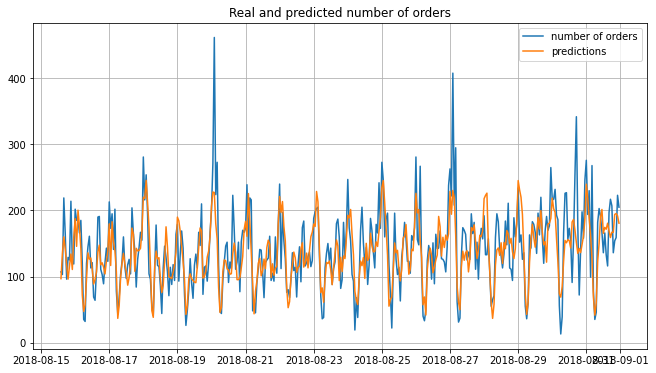

In [26]:
predictions = pd.Series(model.predict(test_x), index=test_y.index)
fig = plt.figure(figsize=(11,6))

ax = fig.add_subplot(1, 1, 1)
ax.grid()
ax.plot(test_y)
ax.plot(predictions)
plt.legend(['number of orders', 'predictions'])
plt.title('Real and predicted number of orders')
plt.show()

На графике видно, что предсказания довольно точно повторяют реальные данные, за исключением участков с очевидными выбросами.

## Вывод

В первой части работы был проведен анализ исходных данных и построены новые признаки для обучения моделей. В ходе анализа удалось установить ряд закономерностей:
- Наблюдается тренд на увеличение скользящего среднего и среднеквадратического отклонения, имеется **глобальный тренда на увеличение заказов**;
- **Количество заказов меняется в течении недели** с пиками в пятницу-субботу и воскресение-понедельник и минимумом в воскресение;
- **Количество заказов менятся в течении дня**, наибольшее количество ночью, около 12 часов, наименьшее к 6 утра.

Эти закономерности указывают на признаки, оказывающие влияние на количество заказов, такие как месяц года, день недели и час дня. Другие построенные признаки: скользящее среднее и значения за предыдущие периоды. Параметры для их определения были определены подбором. Таким образом были получены наборы данных готовые к обучению.

Цель работы - получить модель, осуществляющую предсказания количества заказов на следующий час. Для предсказаний были выбраны модели линейной регрессии, случайного леса, градиентного бустинга. Результаты оценивались метрикой RMSE, и ошибка всех моделей оказалась лучше максимальной заявленной заказчиком и базовой, установленной простой моделью. **Лучшей моделью оказалась LIghtGBM**. Эту модель использовали для предсказаний на тестовой выборке. Полученный результат **RMSE равен 40.242**. Результаты исследований можно применять для дальнейшей разработки предсказательной модели и внедрения в бизнес процесс.